# Fitting a 3D Background Model to NASA TESS data

In [304]:
import numpy as np
from astropy.io import fits

In [305]:
hdulist = fits.open('data/kepler-10_in_TESS.fits')

In [306]:
attrs = ['time', 'flux', 'flux_err', 'quality', 'pos_corr1', 'pos_corr2']
d = {attr:hdulist[1].data[attr] for attr in attrs}
d['quality'] = (d['quality'] & 175) == 0
d['quality'] &= np.isfinite(d['flux']).all(axis=(1, 2)) 
d['quality'] &= np.isfinite(d['flux_err']).all(axis=(1, 2)) 
d['pipeline_mask'] = hdulist[2].data

In [307]:
import numpy as np
import matplotlib.pyplot as plt

[Text(0.5, 0, 'Column'),
 Text(0, 0.5, 'Row'),
 Text(0.5, 1.0, 'Kepler-10 as seen by TESS')]

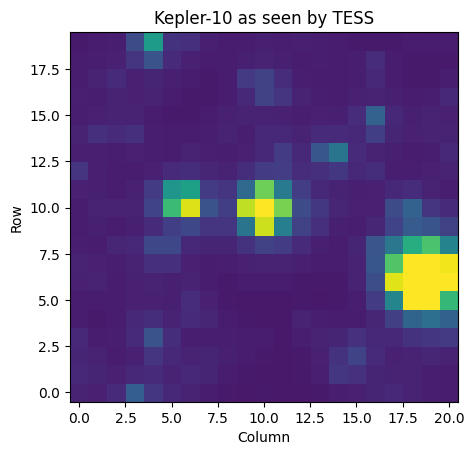

In [308]:
fig, ax = plt.subplots()
ax.imshow(d['flux'][0], vmin=0, vmax=1000, origin='lower')
ax.set(xlabel='Column', ylabel='Row', title='Kepler-10 as seen by TESS')

In [309]:
shape = d['flux'].shape

In [310]:
shape

(1241, 20, 21)

In [311]:
R, C = np.mgrid[:shape[1], :shape[2]]
R = R.astype(float) - R.mean()
C = C.astype(float) - C.mean()

In [312]:
from lamatrix import Fixed, Polynomial, Constant

In [313]:
p1 = Polynomial('r', 1)
p2 = Polynomial('c', 1)
p = p1 + p2 + p1 * p2 + Constant()

In [314]:
mean_frame = d['flux'][630:660].mean(axis=0)
mean_frame -= np.median(mean_frame)

p.fit(data=mean_frame, mask=mean_frame < 50, r=R, c=C)
mean_frame -= p.evaluate(r=R, c=C)

dmean_frame1, dmean_frame2 = np.gradient(mean_frame)
f = np.asarray([dmean_frame1, dmean_frame2]).transpose([1, 2, 0])

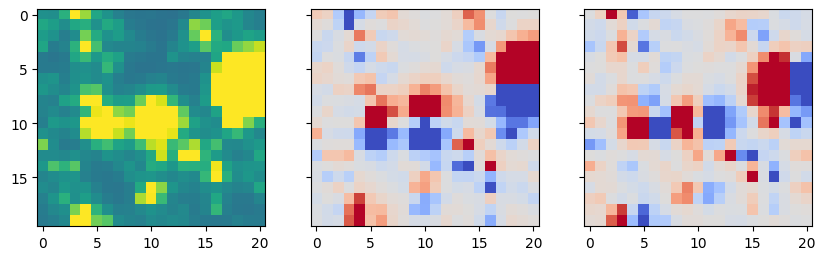

In [315]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
axs[0].imshow(mean_frame, vmin=-100, vmax=100)
axs[1].imshow(dmean_frame1, vmin=-100, vmax=100, cmap='coolwarm')
axs[2].imshow(dmean_frame2, vmin=-100, vmax=100, cmap='coolwarm')

In [316]:
p =  p1 + p2 + p1 * p2 + Constant() + Fixed('f', 2)
p.fit(data=d['flux'][0] - mean_frame, errors=d['flux_err'][0], c=C, r=R, f=f)

In [317]:
p

JointModel
	Polynomial(r)[n, 1]
	Polynomial(c)[n, 1]
	CrosstermModel(r, c)[n, 1]
	Constant()[n, 1]
	Fixed(f)[n, 2]

In [318]:
p[-1]

Fixed(f)[n, 2]

In [319]:
p[-1].posteriors.mean

array([-0.01852726,  0.01152998])

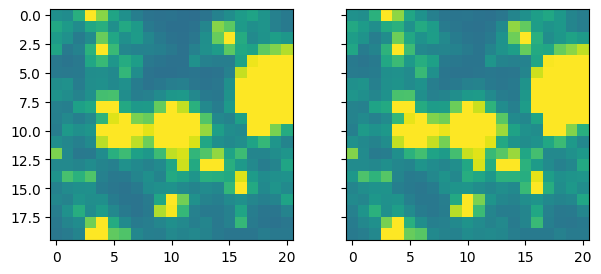

In [320]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
axs[0].imshow(d['flux'][0] - np.nanmedian(d['flux'][0]), vmin=-100, vmax=100)
axs[1].imshow(d['flux'][0] - p[:-1].evaluate(c=C, r=R, f=f), vmin=-100, vmax=100)

In [321]:
bkg, model = np.zeros((2, *shape), float)
shift, shift_err = np.zeros((2, shape[0], 2))
for idx in range(shape[0]):
    p.fit(data=d['flux'][idx] - mean_frame, errors=d['flux_err'][idx], c=C, r=R, f=f)
    model[idx] = p.evaluate(c=C, r=R, f=f)
    bkg[idx] = p[:-1].evaluate(c=C, r=R, f=f)
    shift[idx], shift_err[idx] = p[-1].posteriors.mean, p[-1].posteriors.std

<ErrorbarContainer object of 3 artists>

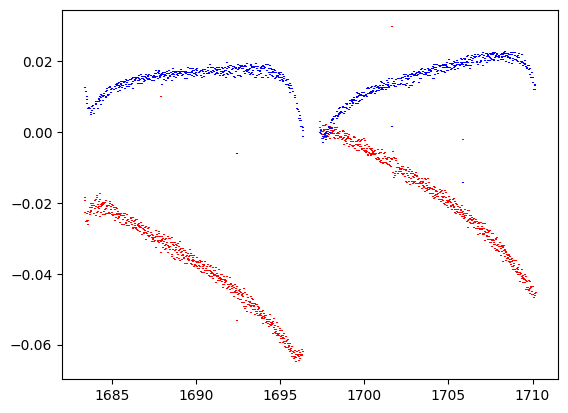

In [322]:
plt.errorbar(d['time'], shift[:, 0], shift_err[:, 0], ls='', c='r')
plt.errorbar(d['time'], shift[:, 1], shift_err[:, 1], ls='', c='b')

In [360]:
chi2 = (1/(shape[0])) * np.sum((d['flux'] - model - mean_frame)**2/(d['flux_err'])**2, axis=0)
bad_pixels = chi2 > 500

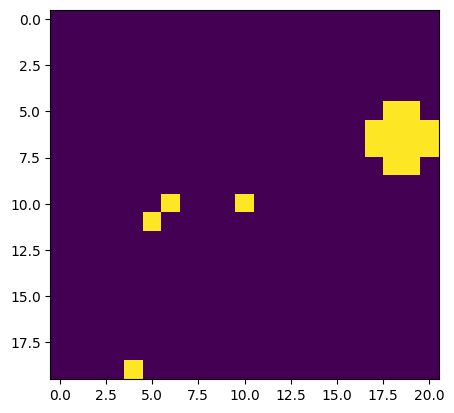

In [361]:
plt.imshow(chi2 > 500)

<ErrorbarContainer object of 3 artists>

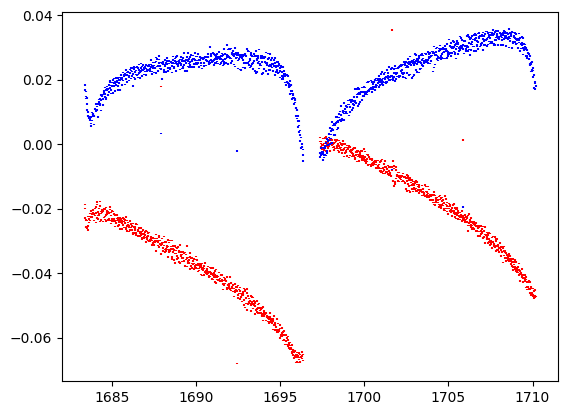

In [362]:
bkg, model = np.zeros((2, *shape), float)
shift, shift_err = np.zeros((2, shape[0], 2))
for idx in range(shape[0]):
    p.fit(data=d['flux'][idx] - mean_frame, errors=d['flux_err'][idx], c=C, r=R, f=f, mask=~bad_pixels)
    model[idx] = p.evaluate(c=C, r=R, f=f)
    bkg[idx] = p[:-1].evaluate(c=C, r=R, f=f)
    shift[idx], shift_err[idx] = p[-1].posteriors.mean, p[-1].posteriors.std
plt.errorbar(d['time'], shift[:, 0], shift_err[:, 0], ls='', c='r')
plt.errorbar(d['time'], shift[:, 1], shift_err[:, 1], ls='', c='b')

In [363]:
r = np.gradient(np.hypot(*(shift - np.median(shift, axis=0)).T), d['time'])
bad_cadences = np.where(r > 0.5)[0] + 1
k = np.ones(shape[0], bool)
k[bad_cadences] = False

In [364]:
aper = np.zeros(shape[1:], bool)
aper[9:12, 9:12] = True

In [365]:
c = ((shift[:, 0, None, None] * f[None, :, :, 0]) + (shift[:, 1, None, None] * f[None, :, :, 1]))

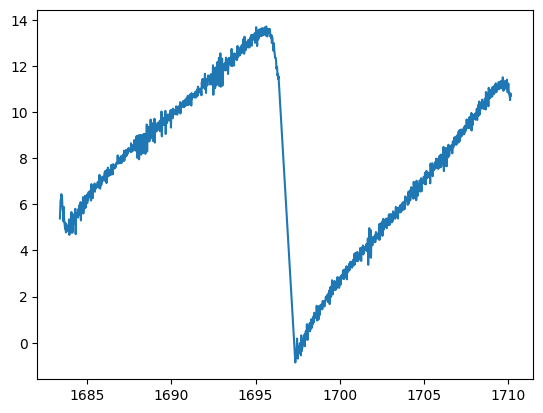

In [366]:
plt.plot(d['time'][k], c[:, aper].sum(axis=1)[k])

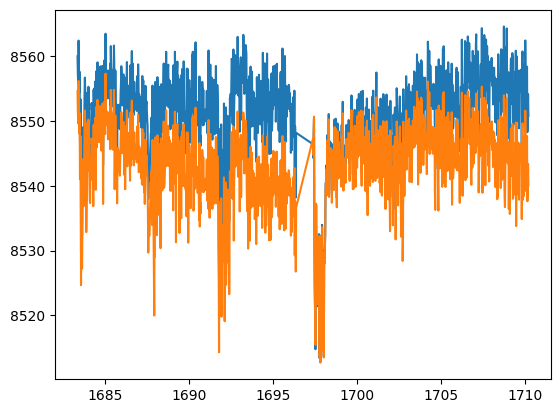

In [368]:
plt.plot(d['time'][k], ((d['flux'] - bkg))[:, aper].sum(axis=(1))[k])
plt.plot(d['time'][k], ((d['flux'] - bkg - c))[:, aper].sum(axis=(1))[k])
# plt.plot(d['time'], l)